<a href="https://colab.research.google.com/github/lameckirungu/supply_chain_simulation/blob/main/supply_chain_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install simpy

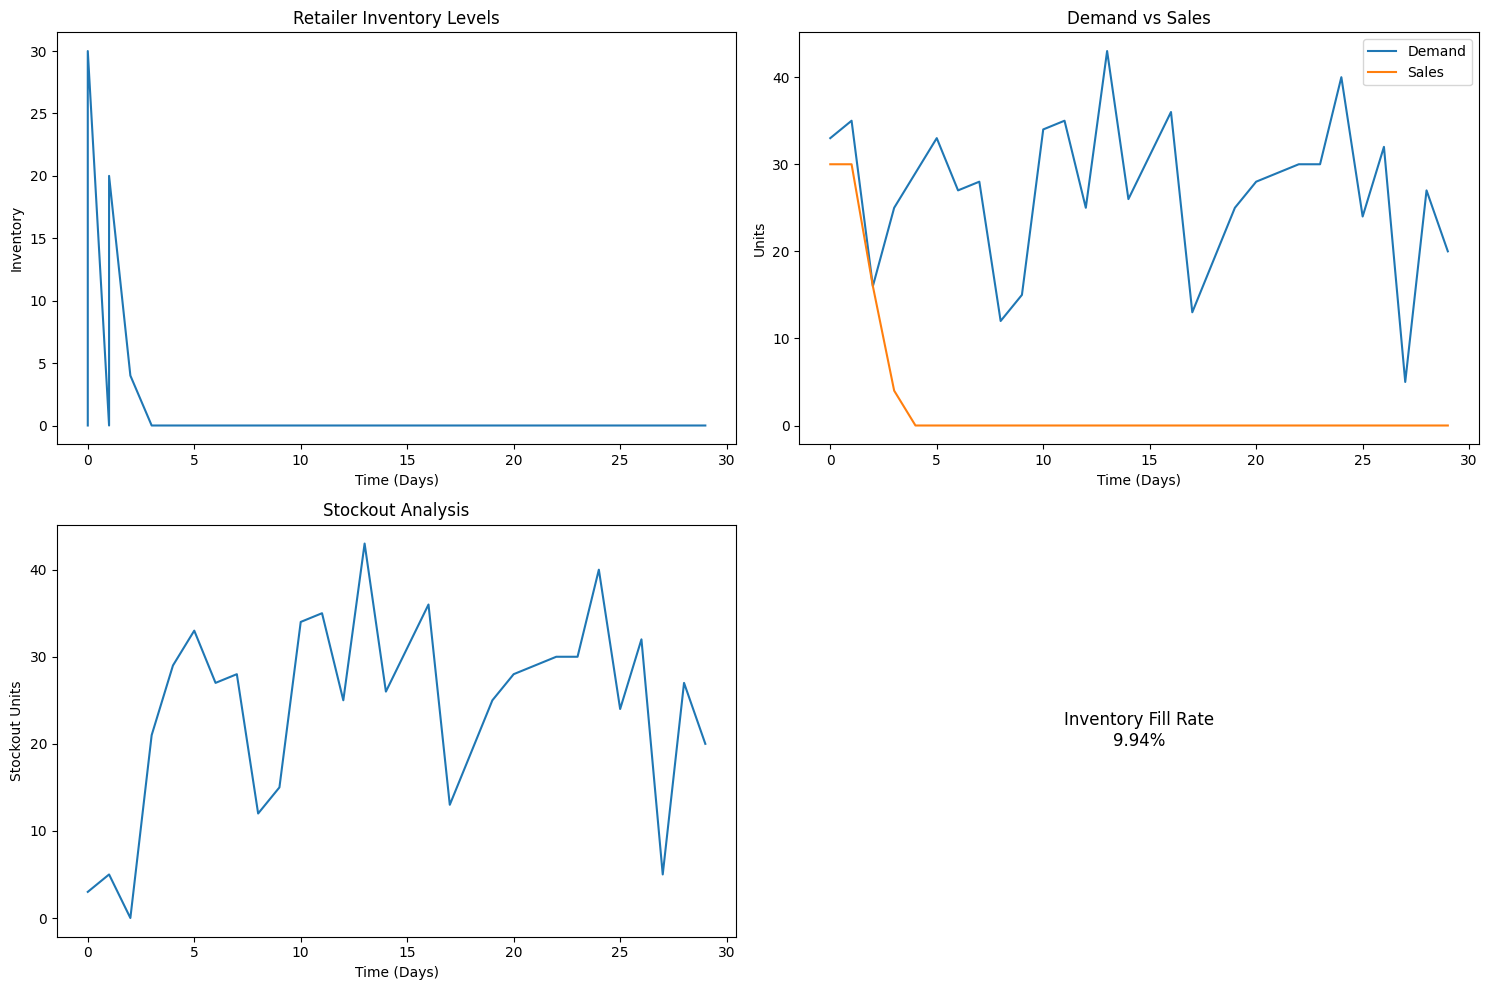


Supply Chain Performance Metrics:
Total Demand: 805 units
Total Sales: 80 units
Total Stockouts: 29
Inventory Fill Rate: 9.94%


In [3]:
import numpy as np
import random
import simpy
import pandas as pd
import matplotlib.pyplot as plt

class SupplyChainEntity:
    """Base class for supply chain entities"""
    def __init__(self, env, name, initial_inventory, max_capacity):
        self.env = env
        self.name = name
        self.inventory = initial_inventory
        self.max_capacity = max_capacity
        self.inventory_history = []

    def record_inventory(self):
        """Record current inventory level"""
        self.inventory_history.append({
            'time': self.env.now,
            'inventory': self.inventory
        })

class Supplier(SupplyChainEntity):
    """Supplier entity that produces items"""
    def __init__(self, env, name, production_rate, lead_time,
                 initial_inventory=100, max_capacity=500):
        super().__init__(env, name, initial_inventory, max_capacity)
        self.production_rate = production_rate
        self.lead_time = lead_time

    def produce(self, order_quantity):
        """Simulate production process"""
        # Wait for production lead time
        yield self.env.timeout(self.lead_time)

        # Produce items, respecting capacity constraints
        produced = min(order_quantity, self.production_rate,
                       self.max_capacity - self.inventory)
        self.inventory += produced
        self.record_inventory()

        return produced

class Warehouse(SupplyChainEntity):
    """Warehouse that stores and distributes inventory"""
    def __init__(self, env, name, reorder_point, order_quantity,
                 initial_inventory=50, max_capacity=300):
        super().__init__(env, name, initial_inventory, max_capacity)
        self.reorder_point = reorder_point
        self.order_quantity = order_quantity

    def check_reorder(self, supplier):
        """Check if reorder is needed"""
        if self.inventory <= self.reorder_point:
            # Place order to supplier
            order_amount = self.order_quantity
            return self.env.process(supplier.produce(order_amount))
        return None

    def fulfill_order(self, order_amount):
        """Fulfill order from retailer"""
        # Determine how much can be shipped
        shipped = min(order_amount, self.inventory)
        self.inventory -= shipped
        self.record_inventory()
        return shipped

class Retailer(SupplyChainEntity):
    """Retailer selling to customers"""
    def __init__(self, env, name, reorder_point, order_quantity,
                 initial_inventory=30, max_capacity=200):
        super().__init__(env, name, initial_inventory, max_capacity)
        self.reorder_point = reorder_point
        self.order_quantity = order_quantity
        self.stockouts = 0
        self.sales_history = []

    def sell(self, demand):
        """Process customer sales"""
        sold = min(demand, self.inventory)
        self.inventory -= sold

        # Track stockouts
        if sold < demand:
            self.stockouts += 1

        # Record sales
        self.sales_history.append({
            'time': self.env.now,
            'demand': demand,
            'sold': sold,
            'stockout': demand - sold
        })

        self.record_inventory()
        return sold

    def check_reorder(self, warehouse):
        """Check if reorder is needed"""
        if self.inventory <= self.reorder_point:
            # Place order to warehouse
            order_amount = self.order_quantity
            shipped = warehouse.fulfill_order(order_amount)
            self.inventory += shipped
            self.record_inventory()
        return None

class SupplyChainSimulation:
    """Main simulation controller"""
    def __init__(self, simulation_days=30):
        self.env = simpy.Environment()
        self.simulation_days = simulation_days
        self.setup_supply_chain()

    def setup_supply_chain(self):
        """Initialize supply chain entities"""
        # Create entities with default parameters
        self.supplier = Supplier(
            self.env,
            "Primary Supplier",
            production_rate=50,
            lead_time=2
        )

        self.warehouse = Warehouse(
            self.env,
            "Central Warehouse",
            reorder_point=30,
            order_quantity=50
        )

        self.retailer = Retailer(
            self.env,
            "Retail Store",
            reorder_point=20,
            order_quantity=30
        )

    def generate_demand(self):
        """Generate random daily demand"""
        return max(0, int(random.normalvariate(25, 10)))

    def run_day(self, day):
        """Simulate a single day in the supply chain"""
        # Generate customer demand
        daily_demand = self.generate_demand()

        # Retailer sells to customers
        self.retailer.sell(daily_demand)

        # Check and place reorders
        retailer_reorder = self.retailer.check_reorder(self.warehouse)
        warehouse_reorder = self.warehouse.check_reorder(self.supplier)

        # Ensure that reorders are processed
        if retailer_reorder:
            yield retailer_reorder
        if warehouse_reorder:
            yield warehouse_reorder

    def run(self):
        """Run full simulation"""
        # Simulate each day
        for day in range(self.simulation_days):
            self.env.process(self.run_day(day))
            self.env.run(until=day+1)

    def analyze_results(self):
        """Analyze and visualize simulation results"""
        # Convert histories to DataFrames
        retailer_inventory = pd.DataFrame(self.retailer.inventory_history)
        supplier_inventory = pd.DataFrame(self.supplier.inventory_history)
        sales_data = pd.DataFrame(self.retailer.sales_history)

        # Create visualization
        plt.figure(figsize=(15, 10))

        # Inventory levels
        plt.subplot(2, 2, 1)
        plt.plot(retailer_inventory['time'], retailer_inventory['inventory'], label='Retailer')
        plt.title('Retailer Inventory Levels')
        plt.xlabel('Time (Days)')
        plt.ylabel('Inventory')

        # Sales and Demand
        plt.subplot(2, 2, 2)
        plt.plot(sales_data['time'], sales_data['demand'], label='Demand')
        plt.plot(sales_data['time'], sales_data['sold'], label='Sales')
        plt.title('Demand vs Sales')
        plt.xlabel('Time (Days)')
        plt.ylabel('Units')
        plt.legend()

        # Stockout Analysis
        plt.subplot(2, 2, 3)
        plt.plot(sales_data['time'], sales_data['stockout'], label='Stockouts')
        plt.title('Stockout Analysis')
        plt.xlabel('Time (Days)')
        plt.ylabel('Stockout Units')

        # Inventory Fill Rate
        fill_rate = (sales_data['sold'].sum() / sales_data['demand'].sum()) * 100
        plt.subplot(2, 2, 4)
        plt.text(0.5, 0.5, f'Inventory Fill Rate\n{fill_rate:.2f}%',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=12)
        plt.axis('off')

        plt.tight_layout()
        plt.show()  # Display the plot instead of saving

        # Print key metrics
        print("\nSupply Chain Performance Metrics:")
        print(f"Total Demand: {sales_data['demand'].sum()} units")
        print(f"Total Sales: {sales_data['sold'].sum()} units")
        print(f"Total Stockouts: {self.retailer.stockouts}")
        print(f"Inventory Fill Rate: {fill_rate:.2f}%")

# Run the simulation
if __name__ == "__main__":
    # Create and run simulation
    sim = SupplyChainSimulation(simulation_days=30)
    sim.run()
    sim.analyze_results()
